# 6. Feature Importance Analysis

## Snippet 6.1 Generating a Set of Informed, Redundant and Noisy Explanatory Variables.

In [1]:
def getTestData(n_features=100, n_informative=25, n_redundant=25, n_samples=10000, random_state=0, sigmaStd=.0):
    #generate random dataset
    from sklearn.datasets import make_classification
    np.random.seed(random_state)
    X,y = make_classification(n_samples=n_samples, n_features=n_features-n_redundant,
                             n_informative=n_informative, n_redundant=0, shuffle=False, random_state=random_state)
    cols = ['I_'+str(i) for i in range(n_informative)]
    cols += ['N_'+str(i) for i in range(n_features-n_informative-n_redundant)]
    X,y = pd.DataFrame(X,columns=cols),pd.Series(y)
    i = np.random.choice(range(n_informative),size=n_redundant)
    for k,j in enumerate(i):
        X['R_'+str(k)] = X['I_'+str(j)]+np.random.normal(size=X.shape[0])*sigmaStd
    return X,y

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import statsmodels.discrete.discrete_model as sm
X,y = getTestData(40,5,30,10000,sigmaStd=.1)
ols = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.380271
         Iterations 7


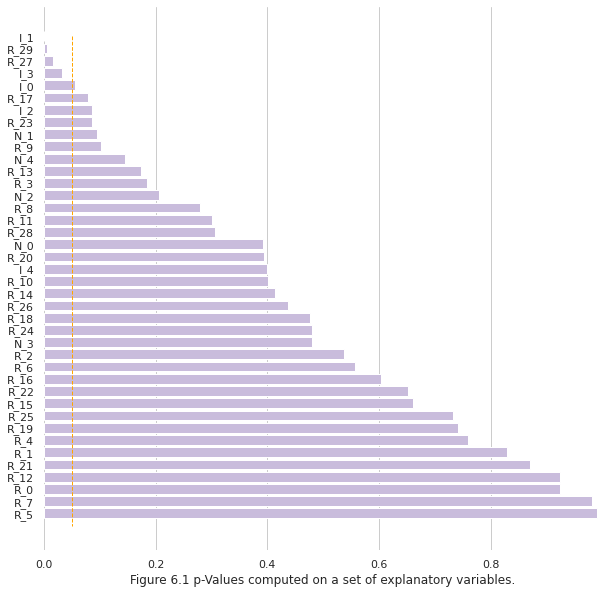

In [2]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Load the example car crash dataset
pval = pd.DataFrame(ols.pvalues.sort_values(ascending=True), columns=["p-value"])

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="p-value", y=pval.index, data=pval, color="#c8b7e1")
plt.vlines(x = 0.05, ymin = 0, ymax = len(pval), color = 'orange', linewidth=1, linestyles='--')
ax.set(xlim=(0, .999), ylabel="",
       xlabel="Figure 6.1 p-Values computed on a set of explanatory variables.")
# ax.grid(False)
sns.despine(left=True, bottom=True)

## Snippet 6.2 Implementation of an Ensemble MDI Method

In [3]:
def featImpMDI(fit, featNames):
    #feature importance based on IS mean impurity redution
    df0 = {i:tree.feature_importances_ for i,tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0,orient='index')
    df0.columns = featNames
    df0 = df0.replace(0, np.nan)
    imp = pd.concat({'mean':df0.mean(), 'std':df0.std()*df0.shape[0]**-.5}, axis=1) #CLT
    imp /= imp['mean'].sum()
    return imp

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

X,y = getTestData(40,5,30,10000,sigmaStd=.1)
clf = DecisionTreeClassifier(criterion='entropy', max_features=1, class_weight='balanced', min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=1000, max_features = 1., max_samples=1., oob_score=False)
fit=clf.fit(X,y)
imp=featImpMDI(fit, featNames=X.columns)

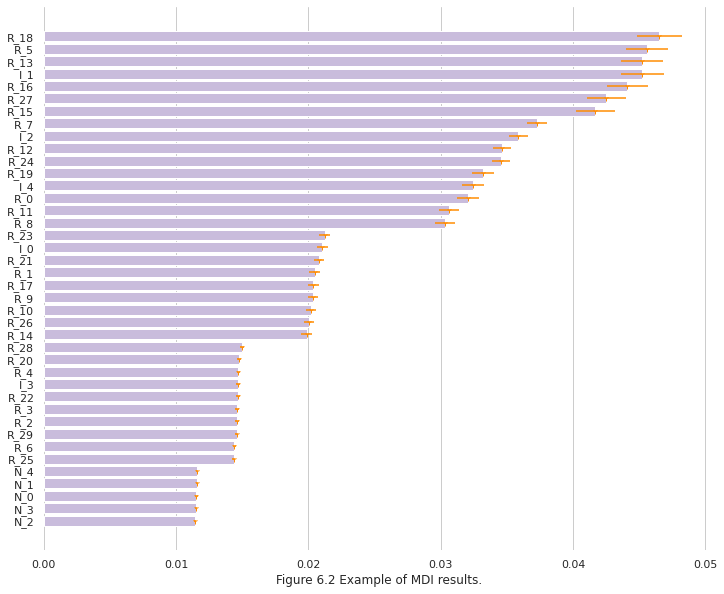

In [4]:
imp.sort_values(by='mean', ascending=False, inplace=True)

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 10))
sns.set_color_codes("pastel")
sns.barplot(x="mean", y=imp.index, data=imp, color="#c8b7e1")
ax.errorbar(x=imp['mean'], y=[i for i in range(len(imp))], xerr=imp['std'], fmt='1', color='darkorange')
ax.set(ylabel="", xlabel="Figure 6.2 Example of MDI results.")
sns.despine(left=True, bottom=True)

## Snippet 6.3 Implememtation of MDA

In [5]:
def featImpMDA(clf, X, y, n_splits=10):
    #feature importance OOS score reduction
    from sklearn.metrics import log_loss
    from sklearn.model_selection._split import KFold
    cvGen = KFold(n_splits=n_splits)
    scr0, scr1 = pd.Series(), pd.DataFrame(columns=X.columns)
    for i, (train, test) in enumerate(cvGen.split(X=X)):
        X0, y0 = X.iloc[train, :], y.iloc[train]
        X1, y1 = X.iloc[test, :], y.iloc[test]
        fit=clf.fit(X=X0, y=y0)
        prob = fit.predict_proba(X1)
        scr0.loc[i] = -log_loss(y1, prob, labels=clf.classes_)
        for j in X.columns:
            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values)
            prob = fit.predict_proba(X1_)
            scr1.loc[i, j] = -log_loss(y1, prob, labels=fit.classes_) 
    imp = (-1*scr1).add(scr0, axis=0)
    imp = imp/(-1*scr1)
    imp = pd.concat({'mean':imp.mean(), 'std':imp.std()*imp.shape[0]**-.5},axis=1) # CLT
    return imp

X,y = getTestData(40,5,30,10000, sigmaStd=.1)
clf = DecisionTreeClassifier(criterion='entropy' ,max_features=1,
class_weight = 'balanced', min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf ,n_estimators=1000,
max_features = 1., max_samples=1., oob_score=False)
imp = featImpMDA(clf,X,y,10)

<ipython-input-5-1b30f93b004f>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scr0, scr1 = pd.Series(), pd.DataFrame(columns=X.columns)


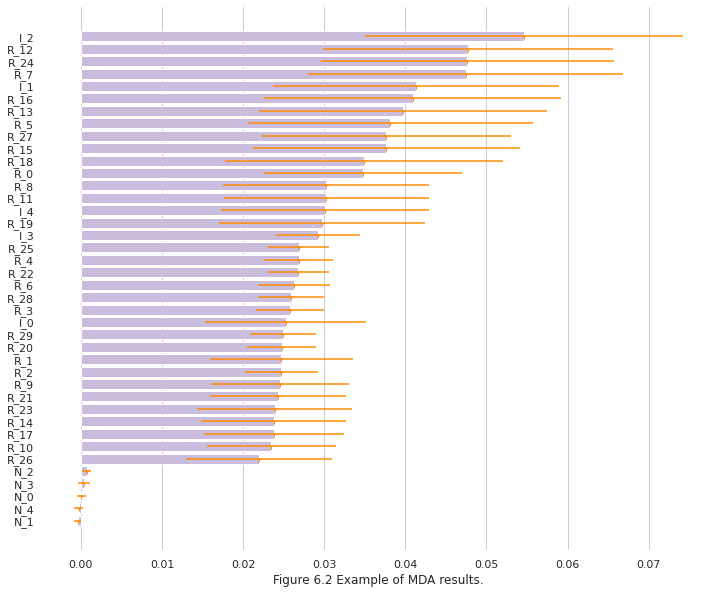

In [6]:
imp.sort_values(by='mean', ascending=False, inplace=True)

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 10))
sns.set_color_codes("pastel")
sns.barplot(x="mean", y=imp.index, data=imp, color="#c8b7e1")
ax.errorbar(x=imp['mean'], y=[i for i in range(len(imp))], xerr=imp['std'], fmt='1', color='darkorange')
ax.set(ylabel="", xlabel="Figure 6.2 Example of MDA results.")
sns.despine(left=True, bottom=True)

# Snippet 6.4 Clustered MDI

In [22]:
def groupMeanStd(df0, clstrs):
    out = pd.DataFrame(columns=['mean','std'])
    for i,j in clstrs.items():
        df1 = df0[j].sum(axis=1)
        out.loc['C_'+str(i),'mean'] = df1.mean()
        out.loc['C_'+str(i),'std'] = df1.std()*df1.shape[0]**-.5
    return out


def featImpMDI_Clustered(fit, featNames, clstrs):
    df0 = {i:tree.feature_importances_ for i,tree in enumerate(fit.estimators_)}
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    df0.columns = featNames
    df0 = df0.replace(0, np.nan) 
    imp = groupMeanStd(df0,clstrs)
    imp /= imp['mean'].sum()
    return imp

# Snippet 6.5 Clustered MDA

In [30]:
def featImpMDA_Clustered(clf, X, y, clstrs ,n_splits=10):
    #feature importance OOS score reduction
    from sklearn.metrics import log_loss
    from sklearn.model_selection._split import KFold
    cvGen = KFold(n_splits=n_splits)
    scr0, scr1 = pd.Series(), pd.DataFrame(columns=clstrs.keys())
    for i, (train, test) in enumerate(cvGen.split(X=X)):
        X0, y0 = X.iloc[train, :], y.iloc[train]
        X1, y1 = X.iloc[test, :], y.iloc[test]
        fit=clf.fit(X=X0, y=y0)
        prob = fit.predict_proba(X1)
        scr0.loc[i] = -log_loss(y1, prob, labels=clf.classes_)
        for j in scr1.columns:
            X1_ = X1.copy(deep=True)
            for k in clstrs[j]:
                np.random.shuffle(X1_[k].values) #shuffle cluster
            prob = fit.predict_proba(X1_)
            scr1.loc[i,j] = -log_loss(y1, prob, labels=clf.classes_)
    imp = (-1*scr1).add(scr0, axis=0)
    imp = imp/(-1*scr1)
    imp = pd.concat({'mean':imp.mean(), 'std':imp.std()*imp.shape[0]**-.5}, axis=1) # CLT
    imp.index = ['C_'+str(i) for i in imp.index]
    return imp

# Snippet 6.6 Features Clustering Step

<ipython-input-9-fa5f91df6ac2>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  x,silh=((1-corr0.fillna(0))/2.)**.5,pd.Series() # observations matrix


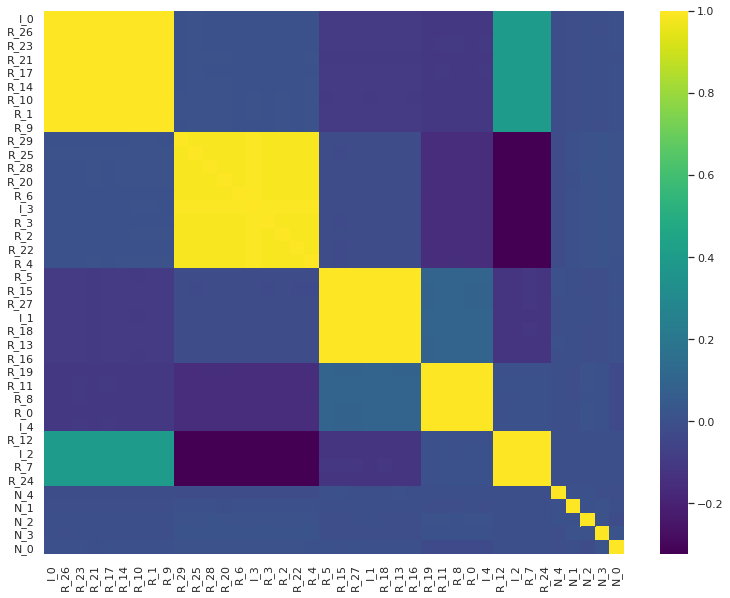

In [9]:
import numpy as np,pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

def clusterKMeansBase(corr0,maxNumClusters=10,n_init=10):
    x,silh=((1-corr0.fillna(0))/2.)**.5,pd.Series() # observations matrix
    for init in range(n_init):
        for i in range(2,maxNumClusters+1):
            kmeans_=KMeans(n_clusters=i,n_jobs=1,n_init=1)
            kmeans_=kmeans_.fit(x)
            silh_=silhouette_samples(x,kmeans_.labels_)
            stat=(silh_.mean()/silh_.std(),silh.mean()/silh.std())
            if np.isnan(stat[1]) or stat[0]>stat[1]:
                silh,kmeans=silh_,kmeans_
                
    newIdx=np.argsort(kmeans.labels_)
    corr1=corr0.iloc[newIdx] # reorder rows
    corr1=corr1.iloc[:,newIdx] # reorder columns
    clstrs={i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_) } # cluster members
    silh=pd.Series(silh,index=x.index)
    return corr1,clstrs,silh

#=================================================

X,y = getTestData(40,5,30,10000, sigmaStd=.1)
corr0, clstrs, silh = clusterKMeansBase(X.corr(), maxNumClusters=10, n_init=10)
plt.figure(figsize=(13,10))
sns.heatmap(corr0, cmap='viridis')


# Snippet 6.7 Calling the Functions for Clustered MDI

In [23]:
clf = DecisionTreeClassifier(criterion='entropy', max_features=1, class_weight='balanced', min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
max_features = 1., max_samples=1., oob_score=False)
fit = clf.fit(X,y)
imp = featImpMDI_Clustered(fit, X.columns, clstrs)

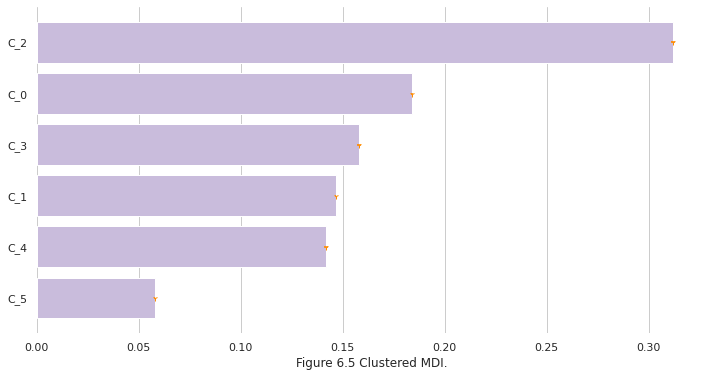

In [28]:
imp.sort_values(by='mean',ascending=False, inplace=True)

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 6))
sns.set_color_codes("pastel")
sns.barplot(x="mean", y=imp.index, data=imp, color="#c8b7e1")
ax.errorbar(x=imp['mean'], y=[i for i in range(len(imp))], xerr=imp['std'], fmt='1', color='darkorange')
ax.set(ylabel="", xlabel="Figure 6.5 Clustered MDI.")
sns.despine(left=True, bottom=True)

# Snippet 6.8 Calling the Functions for Clustered MDA

In [32]:
clf = DecisionTreeClassifier(criterion='entropy', max_features=1, class_weight='balanced', min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
max_features = 1., max_samples=1., oob_score=False)
fit = clf.fit(X,y)
imp = featImpMDA_Clustered(clf, X, y, clstrs, 10)

<ipython-input-30-aa25930bdc49>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scr0, scr1 = pd.Series(), pd.DataFrame(columns=clstrs.keys())


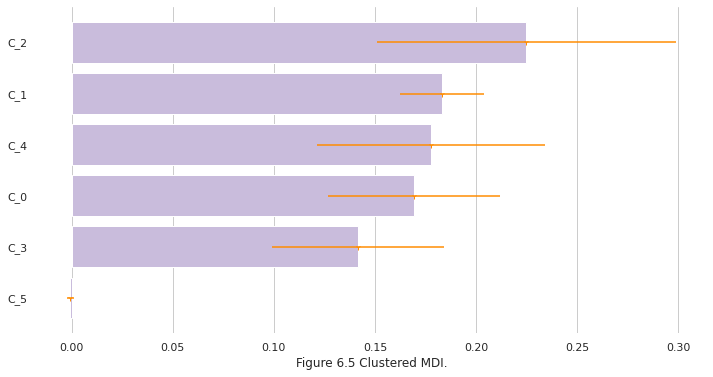

In [33]:
imp.sort_values(by='mean',ascending=False, inplace=True)

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 6))
sns.set_color_codes("pastel")
sns.barplot(x="mean", y=imp.index, data=imp, color="#c8b7e1")
ax.errorbar(x=imp['mean'], y=[i for i in range(len(imp))], xerr=imp['std'], fmt='1', color='darkorange')
ax.set(ylabel="", xlabel="Figure 6.5 Clustered MDI.")
sns.despine(left=True, bottom=True)